# 

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib

In [1]:
!pip install Pillow==9.5.0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [41]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Dropout, Reshape, Dense
from tensorflow.keras.layers import Conv2D, LSTM, ConvLSTM2D, TimeDistributed, Conv2DTranspose
from tensorflow.keras import backend as K
import os

In [42]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [43]:
hasGPUSupport = tf.test.is_built_with_cuda()
gpuList = tf.config.list_physical_devices('GPU')
print("Tensorflow Compiled with CUDA/GPU Support:", hasGPUSupport)
print("Tensorflow can access", len(gpuList), "GPU")

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Tensorflow Compiled with CUDA/GPU Support: True
Tensorflow can access 1 GPU
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [44]:
train_dataset,val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/alexe/PycharmProjects/DIPLOM/8k/',
    label_mode='categorical',
    batch_size=64,
    image_size=(128, 128),
    interpolation='area',
    validation_split=0.1,  # Процент данных для валидации
    subset='both',
    seed=123,
    shuffle=True
)
import numpy as np

def process(x, y):
    x /= 128.0
    x -= 1
    return x

normalized_ds = train_dataset.map(process)
normalized_val_ds = val_dataset.map(process)

AUTOTUNE = tf.data.AUTOTUNE

dataset = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE).shuffle(1000)
dataset_val = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE).shuffle(1000)

Found 8091 files belonging to 1 classes.
Using 7282 files for training.
Using 809 files for validation.


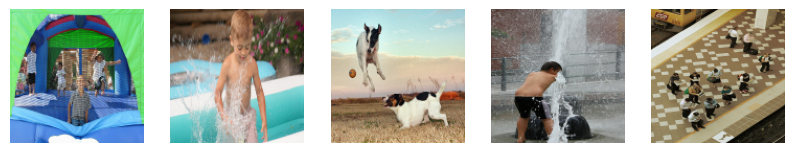

In [45]:
def imshow():    
    n = 5
    plt.figure(figsize=(10, 6))
    for images in dataset_val.take(1):
        for i in range(n):
            img = images[i]
            
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow((img+1)/2, cmap='gist_gray')
            plt.axis('off')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow()

In [46]:
inputs = Input((128, 128, 3))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
res1 = Conv2D(32, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same', strides=2)(res1)
res2 = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same', strides=2)(res2)
x = Dropout(0.1)(x)
res3 = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same', strides=2)(res3)
x = Dropout(0.1)(x)
res4 = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same', strides=2)(res4)
x = Dropout(0.1)(x)
res5 = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same', strides=2)(res5)
x = Dropout(0.1)(x)
res6 = Conv2D(256, 3, activation='relu', padding='same')(x)


# Конвертируем результаты энкодера в последовательности для ConvLSTM2D
convlstm_input = Reshape((-1, 4, 4, 256))(res6)

# Добавляем ConvLSTM2D слои
conv_lstm1 = ConvLSTM2D(128, 3, activation='relu', padding='same', return_sequences=True)(convlstm_input)
conv_lstm2 = ConvLSTM2D(64, 3, activation='relu', padding='same', return_sequences=False)(conv_lstm1)

# Преобразуем результаты ConvLSTM2D обратно в изображения
x = Reshape((4, 4, 64))(conv_lstm2) # Исправлено на 64, так как это количество фильтров в ConvLSTM2D


# Декодер
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
x = Concatenate()([x, res5])
x = Dropout(0.1)(x)
x = Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
x = Concatenate()([x, res4])
x = Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
x = Concatenate()([x, res3])
x = Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = Dropout(0.1)(x)
x = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)
x = Concatenate()([x, res2])
x = Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', padding='same', strides=2)(x)
x = Concatenate()([x, res1])

# Выходной слой
x = Conv2DTranspose(3, 3, activation='linear', padding='same')(x)

outputs = x

unet = keras.Model(inputs, outputs)

In [47]:
class Model(tf.keras.Model):
    def __init__(self, nn_unet):
        super(Model, self).__init__()
        self.nn_unet = nn_unet

        self.unet_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

    def apply_noise(self, x, t):

        noise = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2],1))*5
        for tau in range(2,16):
            noise2 = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1]//tau,tf.shape(x)[2]//tau,1))
            noise2 = tf.image.resize(noise2, (tf.shape(x)[1], tf.shape(x)[2]))
            noise+=noise2
        noise = tf.concat([noise,noise,noise], axis = 3)

        color_noise = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1],tf.shape(x)[2],3))*5
        for tau in range(2,16):
            color_noise2 = tf.random.normal(shape=(tf.shape(x)[0],tf.shape(x)[1]//tau,tf.shape(x)[2]//tau,3))
            color_noise2 = tf.image.resize(color_noise2, (tf.shape(x)[1], tf.shape(x)[2]))
            color_noise+=color_noise2
        noise = noise + color_noise
        noise/=8
        b = 1. - t
        return x*b + noise*t, noise

    def call(self, inputs, training=False):
        return self.nn_unet(inputs, training=training)

    @tf.function
    def training_step(self, x):
        x_n, n = self.apply_noise(x, tf.random.uniform([],0.2,0.3))
        
        with tf.GradientTape() as tape_unet:
            predicted_noise = self.nn_unet(x_n, training=True)
            loss = tf.reduce_mean((predicted_noise - n) ** 2)
        
        grads_e = tape_unet.gradient(loss, self.nn_unet.trainable_variables)
        self.unet_optimizer.apply_gradients(zip(grads_e, self.nn_unet.trainable_variables))
        
        return loss

    @tf.function
    def validation_step(self, x_val):
        x_n_val, n_val = self.apply_noise(x_val, tf.random.uniform([],0.2,0.3))
        predicted_noise_val = self.nn_unet(x_n_val, training=False)
        val_loss = tf.reduce_mean((predicted_noise_val - n_val) ** 2)
        
        return val_loss

In [48]:
model = Model(unet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

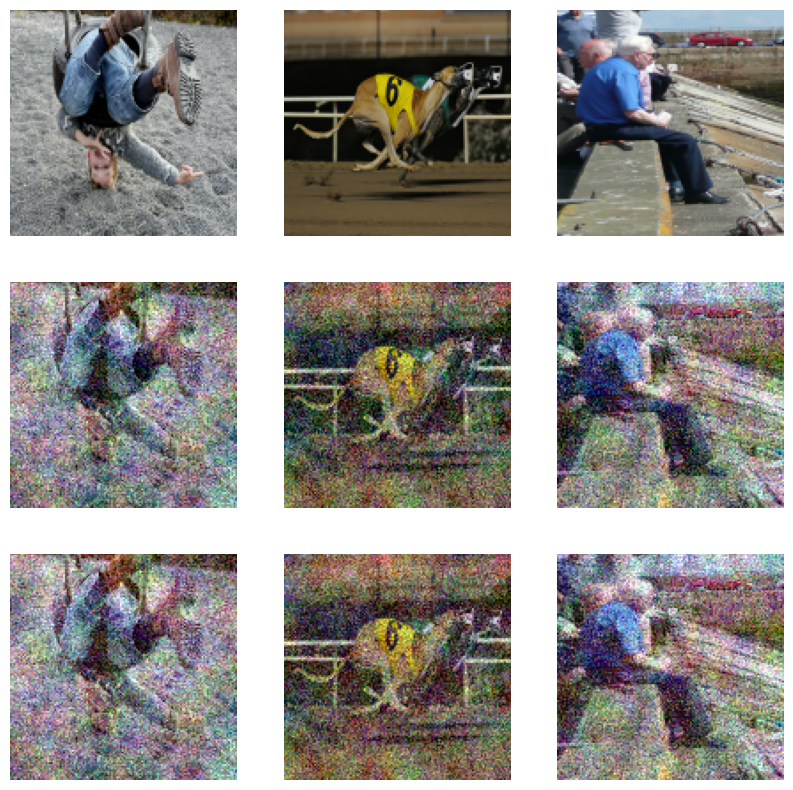

In [49]:
def testing():
    n = 3
    plt.figure(figsize=(10, 10))
    avg_psnr_val = []
    avg_ssim_val = []
    for images in dataset.take(5):
        for i in range(n):
            
            # Display original images
            ax = plt.subplot(3, n, i + 1)
            im = images[i].numpy()
            im = np.squeeze(im)  # Remove the extra dimension
            im2 = (im + 1) / 2
            plt.imshow((im + 1) / 2)
            plt.axis('off')
            ax.get_xaxis().set_visible(False)
            
            # Display noisy images
            nl = tf.random.uniform([], 0.2, 0.3)
            ax = plt.subplot(3, n, i + 1 + n)
            noisy, noise = model.apply_noise(tf.expand_dims(images[i], axis=0), nl)
            noisy = tf.squeeze(noisy, axis=0).numpy()
            noisy = np.clip(noisy, -1, 1)
            im = (noisy + 1) / 2
            plt.imshow(im)
            plt.axis('off')
            ax.get_xaxis().set_visible(False)
            
            # Use neural network to estimate noise
            ax = plt.subplot(3, n, i + 1 + n * 2)
            noise = model.nn_unet(tf.expand_dims(tf.convert_to_tensor(noisy), axis=0)).numpy()
            c = ((noisy - noise * nl) + 1) / 2
            c = np.squeeze(c)  # Remove the extra dimension
            plt.imshow(c)
            plt.axis('off')
            ax.get_xaxis().set_visible(False)


            """
            psnr_val = psnr(im2, c, data_range=255)
            ssim_val = ssim(im2, c, multichannel=True,channel_axis=2,data_range=255)

            avg_psnr_val.append(psnr_val)
            avg_ssim_val.append(ssim_val)

    print(sum(avg_psnr_val) / len(avg_ssim_val))
    print(sum(avg_ssim_val) / len(avg_ssim_val))
            """ 
    plt.show()
    
testing()

Epoch: 100
tf.Tensor(2.5300338, shape=(), dtype=float32)


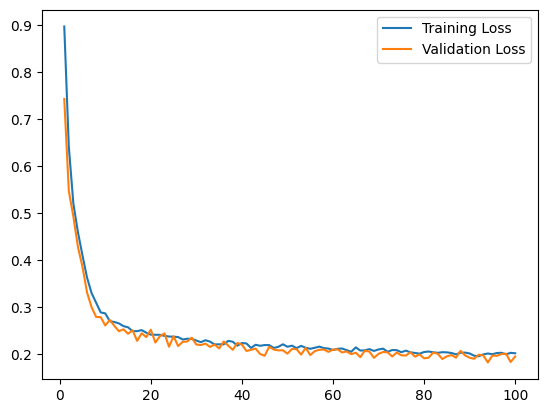

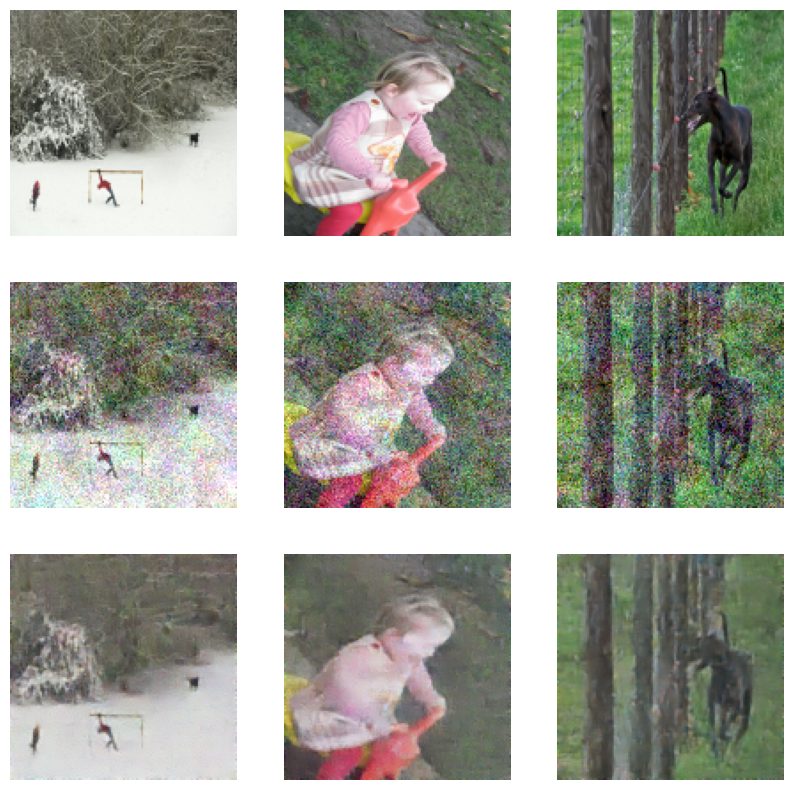

In [11]:
from IPython.display import clear_output

train_hist = []
val_hist = []
epochs = 100

for epoch in range(1, epochs + 1):
    train_loss = 0
    val_loss = 0

    # Training Step
    for step, x_train in enumerate(dataset):
        train_loss += model.training_step(x_train)

    # Validation Step
    for step, x_val in enumerate(dataset_val):
        val_loss += model.validation_step(x_val)

    clear_output(wait=True)
    print(f"Epoch: {epoch}")

    avg_train_loss = train_loss / len(train_dataset)
    train_hist.append(avg_train_loss)
    plt.plot(np.arange(1, epoch+1), train_hist, label='Training Loss')

    avg_val_loss = val_loss / len(val_dataset)
    val_hist.append( avg_val_loss)
    print(val_loss)
    plt.plot(np.arange(1, epoch+1), val_hist, label='Validation Loss')

    plt.legend()
    plt.show()

    testing()

In [12]:
model.nn_unet.save_weights('C:/Users/alexe/PycharmProjects/DIPLOM/denosing_unet_new_3.h5')

In [50]:
model.nn_unet.load_weights('C:/Users/alexe/PycharmProjects/DIPLOM/denosing_unet_new_3.h5')

<h1> Визуализация архитектуры

In [51]:
from keras.utils import plot_model
plot_model(model.nn_unet, to_file='unet_model.png',rankdir="TB",show_dtype=False, show_shapes=False, show_layer_names=True, dpi=5000)

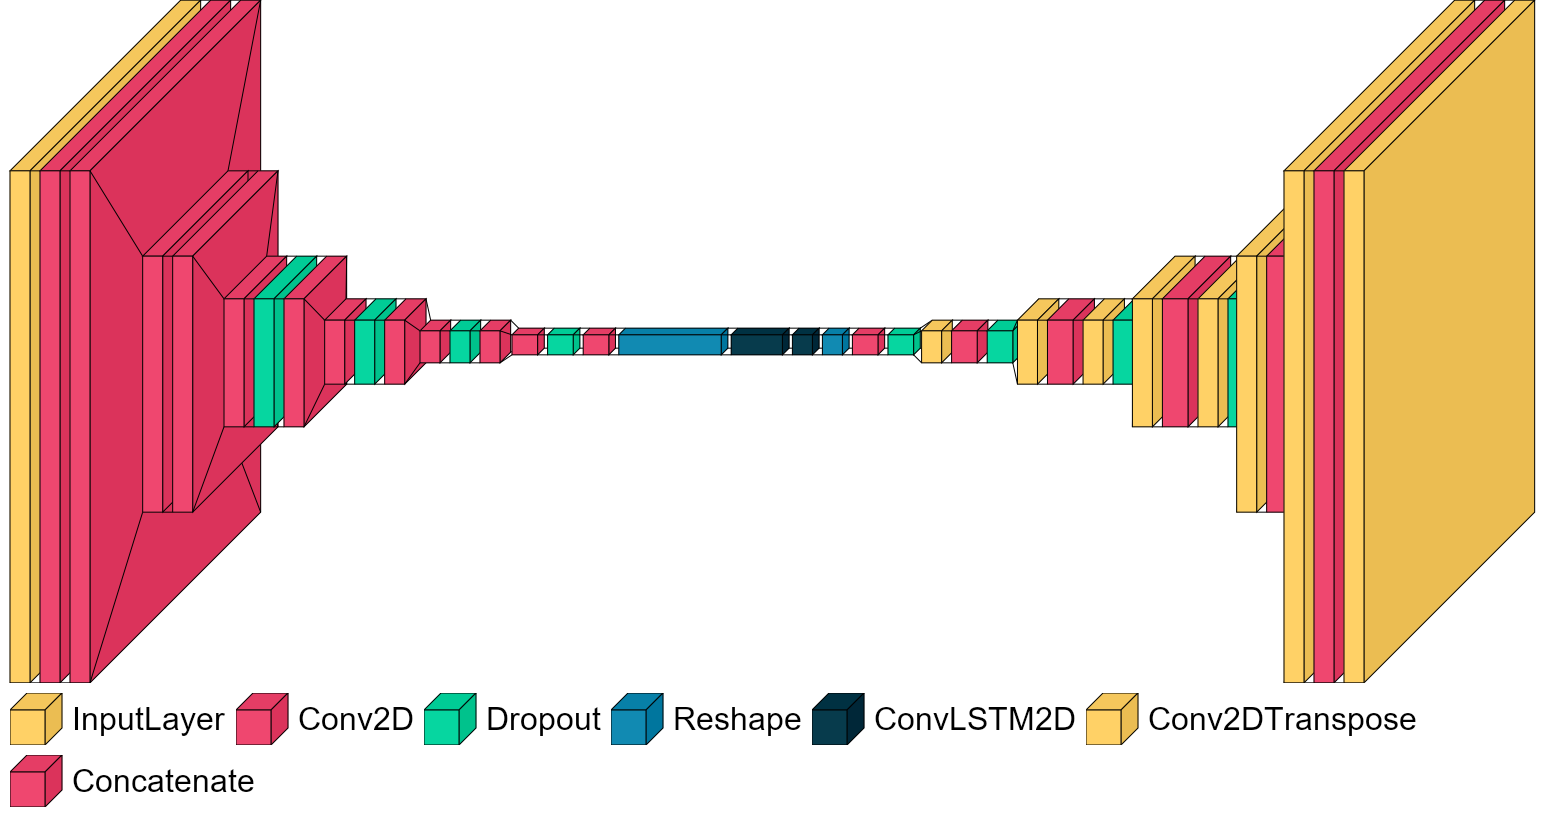

In [52]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model.nn_unet, legend=True, font=font)

<h1> Удаление шума на видео

In [53]:
def denoise_image(image):
    h, w, _ = image.shape
    num_w_cycles = w // 128
    num_h_cycles = h // 128
    out_frame = np.zeros((h, w, 3), dtype=np.float32)

    for h_pos in range(num_h_cycles):
        for w_pos in range(num_w_cycles):
            start_h = h_pos * 128
            end_h = min((h_pos + 1) * 128, h)
            start_w = w_pos * 128
            end_w = min((w_pos + 1) * 128, w)
            fragment = image[start_h:end_h, start_w:end_w, :]

            if fragment.shape[0] == 128 and fragment.shape[1] == 128:
                tensor = tf.cast(np.expand_dims(fragment, axis=0), tf.float32) / 128 - 1
            else:
                tensor = tf.cast(np.expand_dims(np.pad(fragment, ((0, 128 - fragment.shape[0]), (0, 128 - fragment.shape[1]), (0, 0)), mode='constant'), axis=0), tf.float32) / 128 - 1

            noise_tensor = model.nn_unet(tensor)
            clear = tensor - noise_tensor * 0.1
            clear = clear.numpy()[0]

            if fragment.shape[0] == 128 and fragment.shape[1] == 128:
                out_frame[start_h:end_h, start_w:end_w, :] = clear
            else:
                overlap_h = min(16, fragment.shape[0])
                overlap_w = min(16, fragment.shape[1])
                blended = np.zeros_like(fragment)
                blended[:overlap_h, :overlap_w, :] = clear[:overlap_h, :overlap_w, :]
                blended[overlap_h:end_h-start_h, overlap_w:end_w-start_w, :] = clear[overlap_h:, overlap_w:, :]
                out_frame[start_h:end_h, start_w:end_w, :] = blended

    return np.clip((out_frame + 1) / 2, 0, 1)

In [54]:
import cv2
def video_denoise(video_path):
    """
    Удаляет шум из видео, используя модель для удаления шума.
    
    Args:
        video_path (str): Путь к входному видеофайлу.
    """
    path = "C:/Users/alexe/PycharmProjects/DIPLOM/"
    
    # Открываем видео
    cap = cv2.VideoCapture(path + video_path)
    
    # Получаем размеры кадра
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Определяем кодек в зависимости от расширения файла
    if video_path.endswith('.mp4'):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    elif video_path.endswith('.avi'):
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    else:
        raise ValueError("Невозможно определить формат видео. Пожалуйста, укажите формат явно.")
    
    # Создаем объект VideoWriter str(path + 'denoised_' + video_path)
    result = cv2.VideoWriter(str(path + 'denoised_' + video_path), fourcc, fps, (width*2, height))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        new_width = (width // 128 +1)*128
        new_height = (height // 128 +1)*128
        
        frame = tf.image.resize(frame, (new_width, new_height), method='area').numpy()

        a = denoise_image(frame)
        if a is not None:
            a = denoise_image(a * 255)
            a = cv2.resize(a, (width, height)).copy()
            frame = cv2.resize(frame, (width, height))
            b = np.concatenate((frame / 255, a), axis=1)

            b *= 255
            b = np.clip(b, 0, 255)
            ub = b.astype(np.uint8)
            cv2.imshow('frame', ub)
            result.write(ub)

        if cv2.waitKey(1) == ord('q'):
            break

    # Освобождение ресурсов
    cap.release()
    result.release()
    cv2.destroyAllWindows()

In [23]:
video_denoise("noise_snowboard.avi")

<h1>Работа модели на 1 изображении

In [36]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2

In [37]:
dataset_dir = 'C:/Users/alexe/PycharmProjects/DIPLOM/kodak_noise/'
noise_10 = dataset_dir + "noise_30/"
original = 'C:/Users/alexe/PycharmProjects/DIPLOM/kodak_noise/original_png/'

In [38]:
def denoise_single_image(model, noisy_image):
    # Preprocess the noisy image
    tensor = tf.cast(noisy_image, tf.float32) / 128 - 1
    #tensor = tf.image.resize(tensor, (128, 128))
    tensor = tf.expand_dims(tensor, axis=0)
    
    # Apply the neural network to remove noise
    noise_tensor = model.nn_unet(tensor)
    clear = tensor - noise_tensor * 0.1
    clear = tf.squeeze(clear, axis=0)
    clear = clear.numpy()
    clear = (clear + 1) / 2

    return clear

PSNR: 29.140040558137144
SSIM: 0.8050606553932576


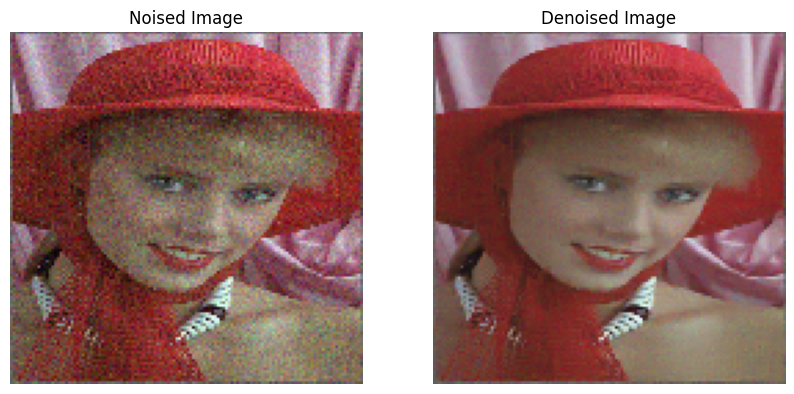

In [39]:
#image = cv2.imread(image_path)
image_path = noise_10 + "kodim04.png"
#image_path = 'C:/Users/alexe/PycharmProjects/DIPLOM/8k/0000.png'
original_image = original + "kodim04.png"
image = cv2.imread(image_path)
original_image = cv2.imread(original_image)
original_image = cv2.resize(original_image, (128, 128))
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

if image is not None:
    # Вызов функции для удаления шума
    image = cv2.resize(image, (128, 128))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    denoised_image = denoise_single_image(model, image)

    #denoised_image = cv2.cvtColor((denoised_image *255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    denoised_image = (denoised_image * 255).astype(np.uint8)
    # Отображение оригинального и очищенного изображений
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Noised Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image)
    plt.title("Denoised Image")
    plt.axis('off')


    psnr_val = psnr(original_image, denoised_image)
            
    # Calculate SSIM with explicit window size, data range, and channel axis
    ssim_val = ssim(original_image, denoised_image, multichannel=True, channel_axis=2)

    print("PSNR: "+str(psnr_val))
    print("SSIM: "+str(ssim_val))
    
    plt.show()
else:
    print('Ошибка загрузки изображения. Пожалуйста, убедитесь в правильности пути к изображению.')

In [40]:
def calculate_metrics_for_dataset(model, dataset_dir, noise_level):
    psnr_values = []
    ssim_values = []
    directory_path = f'{dataset_dir}/noise_{noise_level}'
    
    for filename in os.listdir(directory_path): 
        image_path = f'{dataset_dir}/noise_{noise_level}/{filename}'
        original_image = cv2.imread(f'{dataset_dir}/original_png/{filename}')
        noisy_image = cv2.imread(image_path)
        
        if original_image is not None and noisy_image is not None:
            #original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)

            # Ensure images have the same dimensions
            original_image = cv2.resize(original_image, (128, 128))
            
            denoised_image = denoise_single_image(model, noisy_image)

            denoised_image = cv2.cvtColor((denoised_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            #denoised_image = (denoised_image * 255).astype(np.uint8)
            
            # Calculate PSNR
            psnr_val = psnr(original_image, denoised_image)
            
            # Calculate SSIM with explicit window size, data range, and channel axis
            ssim_val = ssim(original_image, denoised_image, multichannel=True, channel_axis=2)
            
            psnr_values.append(psnr_val)
            ssim_values.append(ssim_val)
        else:
            print(f'Ошибка загрузки изображений для индекса {i}')

    psnr_values = sum(psnr_values) / len(psnr_values)
    ssim_values = sum(ssim_values) / len(ssim_values)
    return psnr_values, ssim_values

# Пример использования:
psnr_values, ssim_values = calculate_metrics_for_dataset(model, 'C:/Users/alexe/PycharmProjects/DIPLOM/kodak_noise', 10)
print('Average PSNR values:', psnr_values)
print('Average SSIM values:', ssim_values)

Average PSNR values: 32.08410084172236
Average SSIM values: 0.9163579799157264


<h1>Добавление шума в тестовый датасет

In [132]:
def apply_noise_2(frame, t):
    if frame is None or frame.size == 0:
        return frame

    # Создаем гауссовский шум
    noise = np.random.normal(0, t, frame.shape)

    # Добавляем шум к кадру
    noisy_frame = np.clip(frame.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Нормализуем изображение, чтобы сохранить контрастность
    noisy_frame = cv2.normalize(noisy_frame, None, 0, 255, cv2.NORM_MINMAX)

    return noisy_frame

In [750]:
def add_noise_to_images(folder_path,output_folder):
    noise_levels = [10, 30, 50]

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            frame = cv2.imread(os.path.join(folder_path, filename))
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #frame = cv2.resize(frame, (1024, 1024))
            
            for t in noise_levels:
                noisy_frame = apply_noise_2(frame, t)
                noisy_frame = cv2.resize(noisy_frame, (128, 128))
                noisy_filename = f'{filename}'
                noisy_folder = os.path.join(output_folder, f'noise_{t}')
                if not os.path.exists(noisy_folder):
                    os.makedirs(noisy_folder)
                cv2.imwrite(os.path.join(noisy_folder, noisy_filename), noisy_frame)


folder_path = 'C:/Users/alexe/PycharmProjects/DIPLOM/Urban100'
output_folder = 'C:/Users/alexe/PycharmProjects/DIPLOM/Urban100_noise'
add_noise_to_images(folder_path, output_folder)

<h1>Добавление шума на видео

In [248]:
import cv2

In [249]:
def apply_noise_to_video(video_path, output_path, t):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Не удалось открыть видео: {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    #print(width)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #print(height)

    if video_path.endswith('.mp4'):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    elif video_path.endswith('.avi'):
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    if not out.isOpened():
        print(f"Не удалось создать выходной файл: {output_path}")
        cap.release()
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            noisy_frame = apply_noise_2(frame, t)
            out.write(noisy_frame)
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    finally:
        cap.release()
        out.release()

def apply_noise(frame, t):
    if frame is None or frame.size == 0:
        return frame

    # Создаем гауссовский шум
    noise = np.random.normal(0, 1, frame.shape).astype(np.uint8)
    
    # Добавляем шум к кадру
    noisy_frame = cv2.addWeighted(frame, 1 - t, noise, t, 0)

    return noisy_frame

In [250]:
apply_noise_to_video('C:/Users/alexe/PycharmProjects/DIPLOM/20532935-hd_1280_720_24fps.mp4','C:/Users/alexe/PycharmProjects/DIPLOM/noised_20532935-hd_1280_720_24fps.mp4', 40)